In [147]:
import pickle
import pandas as pd
import xgboost as xgb
import numpy as np

from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras

import seaborn as sns
import matplotlib.pylab as plt

## Model Comparison

This notebook serves to run a comparison of various models on the existing Proboscidia and Felid datasets in order to determine the most promising model, to be used. 

Models to be compared include: 
- Decision Tree
- Random Forest
- XG Boost
- AdaBoost
- Neural Network

Please note that the data transformation pipelines, make use of oversampling in order to reduce the dataset imbalance. And where available the below models will weight the classes during training.

Initialize overall classification report collection dataframe

In [38]:
report_collection_df = pd.DataFrame()

### Pre-required Methods

In [87]:
# Method to add classification report into a dataframe structure
def add_model_report(report_collection_df: pd.DataFrame, y_val, y_pred, taxon_level:str, model: str):
    classes = y_val.nunique()
    report = classification_report(y_val, y_pred, output_dict=True, zero_division=0)
    
    report_df = pd.DataFrame(report).transpose()
    report_df['taxon_level'] = taxon_level
    report_df['model_type'] = model
    report_df = report_df.head(classes)
    
    return pd.concat([report_collection_df, report_df], sort=False)


# Prep the validation set for Decision tree like models (dt)
def prep_dt_validationSet(df:pd.DataFrame, taxon_target:str):
    taxon_y = df[taxon_target]
    
    if taxon_y.isnull().any():
        df = df.dropna(subset=[taxon_target])
    
    y = df[taxon_target]
    X = df.drop(columns=['taxon_kingdom_name', 'taxon_phylum_name',
                             'taxon_class_name', 'taxon_order_name', 'taxon_family_name',
                             'taxon_genus_name', 'taxon_species_name', 'sub_species', 'common_name'])

    return X, y


# Prep the validation set for Xgboost models (dt)
def prep_xgb_validationSet(df:pd.DataFrame, taxon_target:str):
    taxon_y = df[taxon_target]
    
    if taxon_y.isnull().any():
        df = df.dropna(subset=[taxon_target])
    
    y = df[taxon_target]
    X = df.drop(columns=['taxon_kingdom_name', 'taxon_phylum_name',
                             'taxon_class_name', 'taxon_order_name', 'taxon_family_name',
                             'taxon_genus_name', 'taxon_species_name', 'sub_species', 'common_name'])
    classes = y.nunique()
    
    # Encode labels
    classes = y.nunique()
    lb = LabelBinarizer()
    lb.fit(y)
    y = lb.transform(y)
    
    if classes == 2:
        y = nn_binary_label_handling(y)
    
    return X, y, lb


# If a single label is produced, enforces a double binary format
def nn_binary_label_handling(y):
    return np.hstack((y, 1 - y))


# Convert ohe y-values into correct taxon labels
def convert_to_labels(y_val, y_pred, lb):
    ohe_length = len(y_val[0])
    y_pred_ohe = np.zeros(shape=(len(y_val), ohe_length))
    
    y_val = pd.Series(lb.inverse_transform(y_val))
    y_pred_indices = np.argmax(y_pred, axis=1)
    
    for i in range(len(y_val)):
        y_pred_ohe[i, y_pred_indices[i]] = 1
    y_pred = lb.inverse_transform(y_pred_ohe)
    return y_val, y_pred


# Prep the validation set for Neural network models (dt)
def prep_nn_validationSet(df:pd.DataFrame, taxon_target:str):
    taxon_y = df[taxon_target]
    
    if taxon_y.isnull().any():
        df = df.dropna(subset=[taxon_target])
    
    y = df[taxon_target]
    X = df.drop(columns=['taxon_kingdom_name', 'taxon_phylum_name',
                             'taxon_class_name', 'taxon_order_name', 'taxon_family_name',
                             'taxon_genus_name', 'taxon_species_name', 'sub_species', 'common_name'])
    
    classes = y.nunique()
    
    # Encode labels
    classes = y.nunique()
    lb = LabelBinarizer()
    lb.fit(y)
    y = lb.transform(y)
    
    if classes == 2:
        y = nn_binary_label_handling(y)
    
    
    # Normalize numerical columns in the dataset
    norm_columns = ['apparent_temperature', 'apparent_temperature_max', 'apparent_temperature_min',
                    'cloudcover', 'cloudcover_high', 'cloudcover_low', 'cloudcover_mid', 'dewpoint_2m',
                    'diffuse_radiation', 'direct_radiation', 'elevation', 'et0_fao_evapotranspiration_daily',
                    'et0_fao_evapotranspiration_hourly', 'precipitation', 'precipitation_hours',
                    'precipitation_sum', 'rain', 'rain_sum', 'relativehumidity_2m', 'shortwave_radiation',
                    'shortwave_radiation_sum', 'snowfall', 'snowfall_sum', 'soil_moisture_0_to_7cm',
                    'soil_moisture_28_to_100cm', 'soil_moisture_7_to_28cm', 'soil_temperature_0_to_7cm',
                    'soil_temperature_28_to_100cm', 'soil_temperature_7_to_28cm', 'surface_pressure',
                    'temperature_2m', 'temperature_2m_max', 'temperature_2m_min', 'vapor_pressure_deficit',
                    'winddirection_100m', 'winddirection_10m', 'winddirection_10m_dominant',
                    'windgusts_10m', 'windgusts_10m_max', 'windspeed_100m', 'windspeed_10m',
                    'windspeed_10m_max']

    X[norm_columns] = StandardScaler().fit_transform(X[norm_columns])
    return X, y, lb

## Proboscidia Dataset

### Decision Tree

#### Genus Taxonomy

Load the model

In [29]:
dt_proboscidia_genus_model = pickle.load(open('model_comparison_cache/Elephantidae_family_dt_model.sav', 'rb'))

Import the evaluation Dataset.

In [33]:
dt_genus_df_val = pd.read_csv('model_comparison_cache/Elephantidae_family_dt_validation.csv', index_col=0)

Generate True labels and predicted labels

In [34]:
X_val, y_val = prep_dt_validationSet(dt_genus_df_val, 'taxon_genus_name')
y_pred = dt_proboscidia_genus_model.predict(X_val)

Classification report

In [35]:
proboscidia_genus_df_report = classification_report(y_val, y_pred)
print(proboscidia_genus_df_report)

              precision    recall  f1-score   support

     Elephas       1.00      1.00      1.00        10
   Loxodonta       1.00      1.00      1.00        10

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20



Save classification report for model comparison

In [39]:
report_collection_df = add_model_report(report_collection_df, y_val, y_pred, 'Genus', 'Decision tree')

In [40]:
report_collection_df

,precision,recall,f1-score,support,taxon_level,model_type
Elephas,1.0,1.0,1.0,10.0,Genus,Decision tree
Loxodonta,1.0,1.0,1.0,10.0,Genus,Decision tree


#### Species Taxonomy

Note, Elephas Genus only contains a single species, such that model would not be required, due to the single species possibility.

##### Loxodonta

In [42]:
dt_loxodonta_species_model = pickle.load(open('model_comparison_cache/Loxodonta_genus_dt_model.sav', 'rb'))

In [43]:
dt_species_df_val = pd.read_csv('model_comparison_cache/Loxodonta_genus_dt_validation.csv', index_col=0)

In [44]:
X_val, y_val = prep_dt_validationSet(dt_species_df_val, 'taxon_species_name')
y_pred = dt_loxodonta_species_model.predict(X_val)

In [45]:
loxodonta_species_dt_report = classification_report(y_val, y_pred)
print(loxodonta_species_dt_report)

                    precision    recall  f1-score   support

Loxodonta africana       0.77      1.00      0.87        10
Loxodonta cyclotis       1.00      0.70      0.82        10

          accuracy                           0.85        20
         macro avg       0.88      0.85      0.85        20
      weighted avg       0.88      0.85      0.85        20



In [46]:
report_collection_df = add_model_report(report_collection_df, y_val, y_pred, 'Species', 'Decision tree')

In [47]:
report_collection_df.head()

,precision,recall,f1-score,support,taxon_level,model_type
Elephas,1.000000,1.0,1.000000,10.0,Genus,Decision tree
Loxodonta,1.000000,1.0,1.000000,10.0,Genus,Decision tree
Loxodonta africana,0.769231,1.0,0.869565,10.0,Species,Decision tree
Loxodonta cyclotis,1.000000,0.7,0.823529,10.0,Species,Decision tree


#### Elephas Sub-species

In [49]:
dt_elephas_subspecies_model = pickle.load(open('model_comparison_cache/Elephas_maximus_species_dt_model.sav', 'rb'))

In [50]:
dt_subspecies_df_val = pd.read_csv('model_comparison_cache/Elephas_maximus_species_dt_validation.csv', index_col=0)

In [51]:
X_val, y_val = prep_dt_validationSet(dt_subspecies_df_val, 'sub_species')
y_pred = dt_elephas_subspecies_model.predict(X_val)

In [52]:
elephas_subspecies_report = classification_report(y_val, y_pred)
print(elephas_subspecies_report)

                            precision    recall  f1-score   support

Elephas maximus borneensis       1.00      1.00      1.00        10
   Elephas maximus indicus       0.77      1.00      0.87        10
   Elephas maximus maximus       0.83      1.00      0.91        10
Elephas maximus sumatranus       1.00      0.50      0.67        10

                  accuracy                           0.88        40
                 macro avg       0.90      0.88      0.86        40
              weighted avg       0.90      0.88      0.86        40



In [53]:
report_collection_df = add_model_report(report_collection_df, y_val, y_pred, 'Sub-species', 'Decision tree')

In [54]:
report_collection_df.head(10)

,precision,recall,f1-score,support,taxon_level,model_type
Elephas,1.000000,1.0,1.000000,10.0,Genus,Decision tree
Loxodonta,1.000000,1.0,1.000000,10.0,Genus,Decision tree
Loxodonta africana,0.769231,1.0,0.869565,10.0,Species,Decision tree
Loxodonta cyclotis,1.000000,0.7,0.823529,10.0,Species,Decision tree
Elephas maximus borneensis,1.000000,1.0,1.000000,10.0,Sub-species,Decision tree
Elephas maximus indicus,0.769231,1.0,0.869565,10.0,Sub-species,Decision tree
Elephas maximus maximus,0.833333,1.0,0.909091,10.0,Sub-species,Decision tree
Elephas maximus sumatranus,1.000000,0.5,0.666667,10.0,Sub-species,Decision tree


### Random Forest

#### Genus Taxonomy

In [55]:
rf_proboscidia_genus_model = pickle.load(open('model_comparison_cache/Elephantidae_family_rf_model.sav', 'rb'))

In [56]:
rf_genus_df_val = pd.read_csv('model_comparison_cache/Elephantidae_family_rf_validation.csv', index_col=0)

In [57]:
X_val, y_val = prep_dt_validationSet(rf_genus_df_val, 'taxon_genus_name')
y_pred = rf_proboscidia_genus_model.predict(X_val)

In [58]:
proboscidia_genus_rf_report = classification_report(y_val, y_pred)
print(proboscidia_genus_rf_report)

              precision    recall  f1-score   support

     Elephas       1.00      1.00      1.00        10
   Loxodonta       1.00      1.00      1.00        10

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20



In [59]:
report_collection_df = add_model_report(report_collection_df, y_val, y_pred, 'Genus', 'Random forest')

In [60]:
report_collection_df.head(15)

,precision,recall,f1-score,support,taxon_level,model_type
Elephas,1.000000,1.0,1.000000,10.0,Genus,Decision tree
Loxodonta,1.000000,1.0,1.000000,10.0,Genus,Decision tree
Loxodonta africana,0.769231,1.0,0.869565,10.0,Species,Decision tree
Loxodonta cyclotis,1.000000,0.7,0.823529,10.0,Species,Decision tree
Elephas maximus borneensis,1.000000,1.0,1.000000,10.0,Sub-species,Decision tree
Elephas maximus indicus,0.769231,1.0,0.869565,10.0,Sub-species,Decision tree
Elephas maximus maximus,0.833333,1.0,0.909091,10.0,Sub-species,Decision tree
Elephas maximus sumatranus,1.000000,0.5,0.666667,10.0,Sub-species,Decision tree
Elephas,1.000000,1.0,1.000000,10.0,Genus,Random forest
Loxodonta,1.000000,1.0,1.000000,10.0,Genus,Random forest


#### Species Taxonomy

In [61]:
rf_loxodonta_species_model = pickle.load(open('model_comparison_cache/Loxodonta_genus_rf_model.sav', 'rb'))
rf_species_df_val = pd.read_csv('model_comparison_cache/Loxodonta_genus_rf_validation.csv', index_col=0)
X_val, y_val = prep_dt_validationSet(rf_species_df_val, 'taxon_species_name')
y_pred = rf_loxodonta_species_model.predict(X_val)

In [62]:
loxodonta_species_rf_report = classification_report(y_val, y_pred)
print(loxodonta_species_rf_report)

                    precision    recall  f1-score   support

Loxodonta africana       0.83      1.00      0.91        10
Loxodonta cyclotis       1.00      0.80      0.89        10

          accuracy                           0.90        20
         macro avg       0.92      0.90      0.90        20
      weighted avg       0.92      0.90      0.90        20



In [63]:
report_collection_df = add_model_report(report_collection_df, y_val, y_pred, 'Species', 'Random forest')

In [64]:
report_collection_df.tail()

,precision,recall,f1-score,support,taxon_level,model_type
Elephas maximus sumatranus,1.000000,0.5,0.666667,10.0,Sub-species,Decision tree
Elephas,1.000000,1.0,1.000000,10.0,Genus,Random forest
Loxodonta,1.000000,1.0,1.000000,10.0,Genus,Random forest
Loxodonta africana,0.833333,1.0,0.909091,10.0,Species,Random forest
Loxodonta cyclotis,1.000000,0.8,0.888889,10.0,Species,Random forest


#### Sub-species Taxonomy

In [65]:
rf_elephas_subspecies_model = pickle.load(open('model_comparison_cache/Elephas_maximus_species_rf_model.sav', 'rb'))
rf_subspecies_df_val = pd.read_csv('model_comparison_cache/Elephas_maximus_species_rf_validation.csv', index_col=0)
X_val, y_val = prep_dt_validationSet(rf_subspecies_df_val, 'sub_species')
y_pred = rf_elephas_subspecies_model.predict(X_val)

In [66]:
elephas_subspecies_rf_report = classification_report(y_val, y_pred)
print(elephas_subspecies_rf_report)

                            precision    recall  f1-score   support

Elephas maximus borneensis       1.00      0.90      0.95        10
   Elephas maximus indicus       0.62      1.00      0.77        10
   Elephas maximus maximus       0.75      0.90      0.82        10
Elephas maximus sumatranus       1.00      0.30      0.46        10

                  accuracy                           0.78        40
                 macro avg       0.84      0.77      0.75        40
              weighted avg       0.84      0.78      0.75        40



In [99]:
report_collection_df = add_model_report(report_collection_df, y_val, y_pred, 'Sub-species', 'Random forest')

In [100]:
report_collection_df.tail()

,precision,recall,f1-score,support,taxon_level,model_type
Loxodonta cyclotis,1.000,0.7,0.823529,10.0,Species,Random forest
Elephas maximus borneensis,1.000,0.9,0.947368,10.0,Sub-species,Random forest
Elephas maximus indicus,0.625,1.0,0.769231,10.0,Sub-species,Random forest
Elephas maximus maximus,0.750,0.9,0.818182,10.0,Sub-species,Random forest
Elephas maximus sumatranus,1.000,0.3,0.461538,10.0,Sub-species,Random forest


### XGBoost

#### Proboscidia Genus

In [67]:
xgb_proboscidia_genus_model = xgb.XGBClassifier()
xgb_proboscidia_genus_model.load_model('model_comparison_cache/Elephantidae_family_xgb_model.json')

In [68]:
xgb_genus_df_val = pd.read_csv('model_comparison_cache/Elephantidae_family_xgb_validation.csv', index_col=0)

In [69]:
X_val, y_val, lb = prep_xgb_validationSet(xgb_genus_df_val, 'taxon_genus_name')
y_pred = xgb_proboscidia_genus_model.predict(X_val)

In [70]:
y_val, y_pred = convert_to_labels(y_val, y_pred, lb)

In [71]:
proboscidia_genus_xgb_report = classification_report(y_val, y_pred)
print(proboscidia_genus_xgb_report)

              precision    recall  f1-score   support

     Elephas       1.00      1.00      1.00        10
   Loxodonta       1.00      1.00      1.00        10

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20



In [72]:
report_collection_df = add_model_report(report_collection_df, y_val, y_pred, 'Genus', 'Xgboost')

In [73]:
report_collection_df.tail()

,precision,recall,f1-score,support,taxon_level,model_type
Loxodonta,1.000000,1.0,1.000000,10.0,Genus,Random forest
Loxodonta africana,0.833333,1.0,0.909091,10.0,Species,Random forest
Loxodonta cyclotis,1.000000,0.8,0.888889,10.0,Species,Random forest
Elephas,1.000000,1.0,1.000000,10.0,Genus,Xgboost
Loxodonta,1.000000,1.0,1.000000,10.0,Genus,Xgboost


#### Species Taxonomy (Loxodonta)

In [74]:
xgb_loxodonta_species_model = xgb.XGBClassifier()
xgb_loxodonta_species_model.load_model('model_comparison_cache/Loxodonta_genus_xgb_model.json')

In [75]:
xgb_species_df_val = pd.read_csv('model_comparison_cache/Loxodonta_genus_xgb_validation.csv', index_col=0)
X_val, y_val, lb = prep_xgb_validationSet(xgb_species_df_val, 'taxon_species_name')
y_pred = xgb_loxodonta_species_model.predict(X_val)

In [76]:
y_val, y_pred = convert_to_labels(y_val, y_pred, lb)

In [77]:
report_collection_df = add_model_report(report_collection_df, y_val, y_pred, 'Species', 'Xgboost')

In [78]:
report_collection_df.tail()

,precision,recall,f1-score,support,taxon_level,model_type
Loxodonta cyclotis,1.000000,0.8,0.888889,10.0,Species,Random forest
Elephas,1.000000,1.0,1.000000,10.0,Genus,Xgboost
Loxodonta,1.000000,1.0,1.000000,10.0,Genus,Xgboost
Loxodonta africana,1.000000,0.8,0.888889,10.0,Species,Xgboost
Loxodonta cyclotis,0.833333,1.0,0.909091,10.0,Species,Xgboost


#### Sub-species Taxonomy (Elephas maximus)

In [80]:
xgb_elephas_subspecies_model = xgb.XGBClassifier()
xgb_elephas_subspecies_model.load_model('model_comparison_cache/Elephas_maximus_species_xgb_model.json')

In [82]:
xgb_subspecies_df_val = pd.read_csv('model_comparison_cache/Elephas_maximus_species_xgb_validation.csv', index_col=0)
X_val, y_val, lb = prep_xgb_validationSet(xgb_subspecies_df_val, 'sub_species')
y_pred = xgb_elephas_subspecies_model.predict(X_val)

In [83]:
y_val, y_pred = convert_to_labels(y_val, y_pred, lb)

In [84]:
elephas_subspecies_xgb_report = classification_report(y_val, y_pred)
print(elephas_subspecies_xgb_report)

                            precision    recall  f1-score   support

Elephas maximus borneensis       1.00      1.00      1.00        10
   Elephas maximus indicus       0.71      1.00      0.83        10
   Elephas maximus maximus       1.00      1.00      1.00        10
Elephas maximus sumatranus       1.00      0.60      0.75        10

                  accuracy                           0.90        40
                 macro avg       0.93      0.90      0.90        40
              weighted avg       0.93      0.90      0.90        40



In [85]:
report_collection_df = add_model_report(report_collection_df, y_val, y_pred, 'Sub-species', 'Xgboost')

In [86]:
report_collection_df.tail()

,precision,recall,f1-score,support,taxon_level,model_type
Loxodonta cyclotis,0.833333,1.0,0.909091,10.0,Species,Xgboost
Elephas maximus borneensis,1.000000,1.0,1.000000,10.0,Sub-species,Xgboost
Elephas maximus indicus,0.714286,1.0,0.833333,10.0,Sub-species,Xgboost
Elephas maximus maximus,1.000000,1.0,1.000000,10.0,Sub-species,Xgboost
Elephas maximus sumatranus,1.000000,0.6,0.750000,10.0,Sub-species,Xgboost


## Automate Collection

The process above showcases the neccessity of understanding the accuracy, precision and f1 score for all classes within a model. However this process requires automation. Below the process is automated to generate a single dataframe containing all reports

In [25]:
model_abbreviations = {'Neural network': 'nn',
                       'Decision tree': 'dt',
                       'Random forest': 'rf',
                       'Xgboost': 'xgb',
                       'AdaBoost': 'ada'}

In [24]:
def model_selection(model_type: str, file_identifier: str):
    match model_type:
        case 'Neural network':
            model = keras.models.load_model('model_comparison_cache/' + file_identifier +  '_nn_model')
            return model
        case 'Decision tree':
            model = pickle.load(open('model_comparison_cache/' + file_identifier + '_dt_model.sav', 'rb'))
            return model
        case 'Random forest':
            model = pickle.load(open('model_comparison_cache/' + file_identifier + '_rf_model.sav', 'rb'))
            return model
        case 'Xgboost':
            model = xgb.XGBClassifier()
            model.load_model('model_comparison_cache/' + file_identifier + '_xgb_model.json')
            return model
        case 'AdaBoost':
            model = pickle.load(open('model_comparison_cache/' + file_identifier + '_ada_model.sav', 'rb'))
            return model

In [22]:
def validation_set_process(validation_type: str, taxon_target: str, validation_df: pd.DataFrame):
    match validation_type:
        case 'dt':
            X_val, y_val = prep_dt_validationSet(validation_df, taxon_target)
            return X_val, y_val, _
        case 'rf':
            X_val, y_val = prep_dt_validationSet(validation_df, taxon_target)
            return X_val, y_val, _
        case 'ada':
            X_val, y_val = prep_dt_validationSet(validation_df, taxon_target)
            return X_val, y_val, _
        case 'xgb':
            X_val, y_val, lb = prep_xgb_validationSet(validation_df, taxon_target)
            return X_val, y_val, lb
        case 'nn':
            X_val, y_val, lb = prep_nn_validationSet(validation_df, taxon_target)
            return X_val, y_val, lb

In [23]:
taxon_label = {'taxon_genus_name': 'Genus',
              'taxon_species_name': 'Species',
              'sub_species': 'Sub-species'}

In [21]:
def classification_report_collection(report_collection_df: pd.DataFrame, file_identifier: str, model_type: str, data_process: str, taxon_target: str, ohe_status: bool):
    # Create the model
    model = model_selection(model_type, file_identifier)
    
    # Generate validation dataset split
    validation_df = pd.read_csv('model_comparison_cache/' + 
                                file_identifier + '_' + 
                                model_abbreviations[model_type] + 
                                '_validation.csv', index_col=0)

    # Prepare the model's validation set
    X_val, y_val, lb = validation_set_process(data_process, taxon_target, validation_df)
    
    # Predict
    y_pred = model.predict(X_val)
    
    # Convert to labels if ohe
    if ohe_status:
        y_val, y_pred = convert_to_labels(y_val, y_pred, lb)
        
        
    # Add the report to the report collection
    report_collection_df = add_model_report(report_collection_df, y_val, y_pred, taxon_label[taxon_target], model_type)
    return report_collection_df

    

In [20]:
def collection_cycle(report_collection_df: pd.DataFrame, 
                     file_identifiers: list, 
                     model_types: list,
                     taxon_targets: list):
    for i in range(len(model_types)):
        print('------------------------')
        print(model_types[i])
        print('------------------------')
        
        
        for j in range(len(file_identifiers)):
            print(file_identifiers[j])
            report_collection_df = classification_report_collection(report_collection_df=report_collection_df,
                                                                     file_identifier=file_identifiers[j], 
                                                                     model_type=model_types[i], 
                                                                     data_process=data_processes[i],
                                                                     taxon_target=taxon_targets[j],
                                                                     ohe_status=ohe_status_list[i])
    return report_collection_df

In [88]:
report_collection_df = pd.DataFrame()

In [89]:
file_identifiers = ['Elephantidae_family', 'Loxodonta_genus', 'Elephas_maximus_species', 'Felidae_family', 'Lynx_genus', 'Panthera_genus', 'Caracal_genus', 'Leopardus_genus', 'Felis_genus', 'Prionailurus_genus', 'Lynx_rufus_species', 'Panthera_leo_species', 'Panthera_pardus_species', 'Acinonyx_jubatus_species', 'Panthera_tigris_species', 'Puma_concolor_species', 'Leopardus_pardalis_species', 'Felis_lybica_species', 'Leptailurus_serval_species', 'Prionailurus_bengalensis_species']
taxon_targets = ['taxon_genus_name', 'taxon_species_name', 'sub_species', 'taxon_genus_name', 'taxon_species_name', 'taxon_species_name', 'taxon_species_name', 'taxon_species_name', 'taxon_species_name', 'taxon_species_name', 'sub_species', 'sub_species', 'sub_species', 'sub_species', 'sub_species', 'sub_species', 'sub_species', 'sub_species', 'sub_species', 'sub_species']
model_types = ['Neural network', 'Decision tree', 'Random forest', 'Xgboost', 'AdaBoost']
data_processes = ['nn', 'dt', 'rf', 'xgb', 'ada']
ohe_status_list = [True, False, False, True, False]

report_collection_df = collection_cycle(report_collection_df,
                                        file_identifiers, 
                                        model_types,
                                        taxon_targets)

------------------------
Neural network
------------------------
Elephantidae_family
1/1 [==============================] - 0s 27ms/step
Loxodonta_genus
1/1 [==============================] - 0s 26ms/step
Elephas_maximus_species
2/2 [==============================] - 0s 2ms/step
Felidae_family
5/5 [==============================] - 0s 2ms/step
Lynx_genus
2/2 [==============================] - 0s 2ms/step
Panthera_genus
2/2 [==============================] - 0s 3ms/step
Caracal_genus
1/1 [==============================] - 0s 29ms/step
Leopardus_genus
4/4 [==============================] - 0s 2ms/step
Felis_genus
2/2 [==============================] - 0s 2ms/step
Prionailurus_genus
2/2 [==============================] - 0s 2ms/step
Lynx_rufus_species
1/1 [==============================] - 0s 29ms/step
Panthera_leo_species
1/1 [==============================] - 0s 29ms/step
Panthera_pardus_species
2/2 [==============================] - 0s 3ms/step
Acinonyx_jubatus_species
1/1 [===========

In [90]:
report_collection_df.tail(50)

,precision,recall,f1-score,support,taxon_level,model_type
Panthera tigris,0.000000,0.0,0.000000,10.0,Species,AdaBoost
Panthera uncia,1.000000,0.4,0.571429,10.0,Species,AdaBoost
Caracal aurata,1.000000,0.6,0.750000,10.0,Species,AdaBoost
Caracal caracal,0.714286,1.0,0.833333,10.0,Species,AdaBoost
Leopardus colocola,0.230769,0.9,0.367347,10.0,Species,AdaBoost
Leopardus emiliae,0.000000,0.0,0.000000,10.0,Species,AdaBoost
Leopardus garleppi,1.000000,0.7,0.823529,10.0,Species,AdaBoost
Leopardus geoffroyi,0.000000,0.0,0.000000,10.0,Species,AdaBoost
Leopardus guigna,0.000000,0.0,0.000000,10.0,Species,AdaBoost
Leopardus guttulus,0.225806,0.7,0.341463,10.0,Species,AdaBoost


In [91]:
report_collection_df.to_csv('model_comparison_cache/model_comparison_report.csv')

## Model Comparison Analysis

In [94]:
report_collection_df = pd.read_csv('model_comparison_cache/model_comparison_report.csv', index_col=0)

In [95]:
report_collection_df.head()

,precision,recall,f1-score,support,taxon_level,model_type
Elephas,1.000000,1.0,1.000000,10.0,Genus,Neural network
Loxodonta,1.000000,1.0,1.000000,10.0,Genus,Neural network
Loxodonta africana,1.000000,0.8,0.888889,10.0,Species,Neural network
Loxodonta cyclotis,0.833333,1.0,0.909091,10.0,Species,Neural network
Elephas maximus borneensis,1.000000,0.9,0.947368,10.0,Sub-species,Neural network


In [96]:
report_collection_df.shape

(390, 6)

## Genus Level Analysis

In [142]:
genus_df = report_collection_df[report_collection_df['taxon_level'] == 'Genus'].copy()

#### Average Model Scores at Taxon genus

In [134]:
avg_genus_scores = genus_df.groupby(['model_type']).agg({'precision':'mean',
                                                        'recall': 'mean',
                                                       'f1-score': 'mean'})

In [135]:
avg_genus_scores

,precision,recall,f1-score
model_type,,,
AdaBoost,0.285745,0.346667,0.255588
Decision tree,0.543862,0.486667,0.450338
Neural network,0.138462,0.200000,0.142857
Random forest,0.467523,0.333333,0.277115
Xgboost,0.570071,0.413333,0.392387


#### Individaul Genus Level Analysis

In [143]:
genus_df = genus_df.rename_axis('taxonomic_name').reset_index()

In [144]:
genus_df.head()

,taxonomic_name,precision,recall,f1-score,support,taxon_level,model_type
0,Elephas,1.0,1.0,1.0,10.0,Genus,Neural network
1,Loxodonta,1.0,1.0,1.0,10.0,Genus,Neural network
2,Acinonyx,0.0,0.0,0.0,10.0,Genus,Neural network
3,Caracal,0.0,0.0,0.0,10.0,Genus,Neural network
4,Felis,0.0,0.0,0.0,10.0,Genus,Neural network


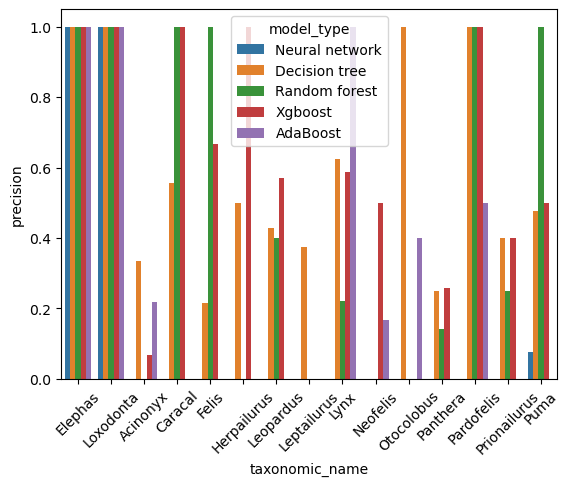

In [148]:
sns.barplot(data=genus_df, x='taxonomic_name', y='precision', hue='model_type')

plt.xticks(rotation=45)
plt.show()

**Analysis**

Meta-data models at the Genus taxonomic level has varied performance. For relatively simple and well-behaved Genus types such as Elephas and Loxondonta, the models performs exceedingly well, however for more imbalanced complicated genus types such as Leopardus the models perform extremely poorly often over-training, and predicting only a single class.